# Step0: defineProb_statement

**Objective**

To develop a machine learning model using a Mulit-layer perceptron (MLP or Multi-Variant) to forecast the closing price of TCS stock for the next 5 days when dataset ended, also plot the trained of close over the whole data based on historical stock price data.




**Step-Taken**


# Step1: Load_Data

In [1]:
# import req library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load the dataset

file_path = 'https://raw.githubusercontent.com/ankit485803/Research_Intern_IIIT_Guwahati/main/data/Finance_Eco/PrepStep_TCS_sep2002%20_NS_June2024.csv'


data = pd.read_csv(file_path)

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

## s(i) EDA

EDA = Exploratory data analysis

In [3]:
# import ydata python library instead of pandas-profiling

# !pip install ydata-profiling

# from ydata_profiling import ProfileReport

# # create profile
# profile = ProfileReport(data)

# # save report
# profile.to_file(output_file='output_TCS.html')

## s(ii) Trail_01_deleteLast_5rows

In [4]:
# Import necessary libraries
import pandas as pd

# Load the dataset
file_path = 'https://raw.githubusercontent.com/ankit485803/Research_Intern_IIIT_Guwahati/main/data/Finance_Eco/PrepStep_TCS_sep2002%20_NS_June2024.csv'

# Display the original dataset
print("Original dataset:")
print(data)

# Remove the last 5 rows
data = data[:-5]

# Display the updated dataset
print("\nUpdated dataset (last 5 rows removed):")
print(data)


Original dataset:
           Date         Open         High          Low        Close  \
0    2002-09-02    44.750000    45.974998    44.049999    44.500000   
1    2002-09-03    44.750000    44.937500    42.000000    42.412498   
2    2002-09-04    41.875000    43.750000    41.387501    43.337502   
3    2002-09-05    44.662498    44.862499    42.500000    43.075001   
4    2002-09-06    43.250000    43.250000    41.012501    41.474998   
...         ...          ...          ...          ...          ...   
5404 2024-06-12  3874.399902  3893.500000  3827.449951  3831.649902   
5405 2024-06-13  3856.800049  3890.000000  3852.000000  3878.149902   
5406 2024-06-14  3889.000000  3889.000000  3828.000000  3832.050049   
5407 2024-06-18  3826.050049  3842.000000  3795.050049  3815.100098   
5408 2024-06-19  3827.649902  3833.850098  3797.000000  3806.399902   

        Adj Close   Volume  
0       31.293869  2389568  
1       29.825882   986784  
2       30.476370  1449856  
3       30.29

# Step2: Data_PreProcessing

## s(i) assign_Dep_Indep_Variable

In [5]:
# this is just for your refence and more clearity



# X1_ref = scaled_data['Open', 'Low', 'High', 'Adj Close', 'Volume']
# Y1_ref = scaled_data['Close']


## this error comes
# IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Solution by Ankit: we have to be carefully while assign dependent + Independent variable i.e. USE INDEXING - METHOD

In [6]:
# Independent variables (X-axis): 'Open', 'Low', 'High', 'Adj Close', 'Volume'
# Dependent variable (Y-axis): 'Close'


X = data[['Open', 'Low', 'High', 'Adj Close', 'Volume']].values
Y = data['Close'].values

In [7]:
X

array([[4.47500000e+01, 4.40499990e+01, 4.59749980e+01, 3.12938690e+01,
        2.38956800e+06],
       [4.47500000e+01, 4.20000000e+01, 4.49375000e+01, 2.98258820e+01,
        9.86784000e+05],
       [4.18750000e+01, 4.13875010e+01, 4.37500000e+01, 3.04763700e+01,
        1.44985600e+06],
       ...,
       [3.83730005e+03, 3.83730005e+03, 3.91500000e+03, 3.89394995e+03,
        4.55244500e+06],
       [3.89500000e+03, 3.84189990e+03, 3.90589990e+03, 3.85869995e+03,
        1.73466100e+06],
       [3.84500000e+03, 3.84100000e+03, 3.87994995e+03, 3.85210010e+03,
        1.41989800e+06]])

## s(ii) Normalize_MinMax_Scale

In [8]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))

Why 60?

Ans: In summary, look_back = 60 means you are using the previous 60 time steps of data to predict the next time step in your time series prediction task. Adjusting this parameter might affect how your model learns from historical data and predicts future values.



*   The choice of look_back = 60 in our example suggests that we are using 60 previous time steps (or data points) to predict the next data point in our time series.




In [9]:
# Create a function to create sequences for LSTM

def create_sequences(X, Y, time_steps=1):
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        Ys.append(Y[i + time_steps])
    return np.array(Xs), np.array(Ys)


time_steps = 60  # Use the past 60 days to predict the next day
X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, time_steps)

## s(iii) split_TrainTest

In [10]:
# Split the data into training and test sets


train_size = int(len(X) * 0.8)  # 80% for training, 20% for testing


X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

# Step3: Build_LSTM_Model

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [12]:
# Define the LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))



model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# summary of  modal

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31451 (122.86 KB)
Trainable params: 31451 (122.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## s(i) Model_Summary_Visualize

In [14]:
# import req library

!sudo apt-get install graphviz

!pip install pydot

from tensorflow.keras.utils import plot_model


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


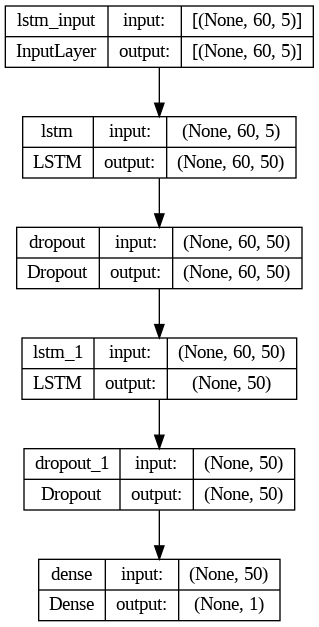

In [15]:
from tensorflow.keras.utils import plot_model

# Generate the plot and save it to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the plot inline (if using a Jupyter notebook)
from IPython.display import Image
Image(filename='model_architecture.png')


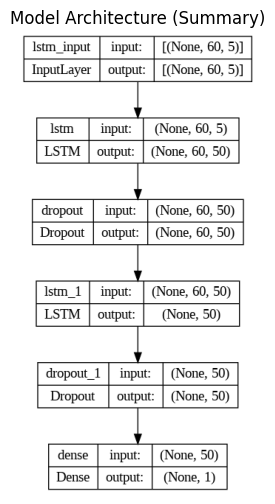

In [16]:
## If you are not using a Jupyter notebook, you can display the plot using matplotlib



img = plt.imread('model_architecture.png')
plt.figure(figsize=(12, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Model Architecture (Summary)')
plt.show()

## s(ii) Compile_Train

In [17]:
# Train the model

history = model.fit(X_seq, Y_seq, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
134/134 [==============================] - 27s 160ms/step - loss: 0.0018 - val_loss: 0.0036
Epoch 2/10
134/134 [==============================] - 10s 76ms/step - loss: 4.8528e-04 - val_loss: 0.0011
Epoch 3/10
134/134 [==============================] - 7s 55ms/step - loss: 4.4902e-04 - val_loss: 7.1074e-04
Epoch 4/10
134/134 [==============================] - 9s 65ms/step - loss: 4.1852e-04 - val_loss: 0.0024
Epoch 5/10
134/134 [==============================] - 7s 54ms/step - loss: 3.7790e-04 - val_loss: 9.5579e-04
Epoch 6/10
134/134 [==============================] - 9s 66ms/step - loss: 3.2229e-04 - val_loss: 0.0051
Epoch 7/10
134/134 [==============================] - 9s 66ms/step - loss: 3.2528e-04 - val_loss: 0.0029
Epoch 8/10
134/134 [==============================] - 7s 54ms/step - loss: 3.2589e-04 - val_loss: 0.0011
Epoch 9/10
134/134 [==============================] - 9s 65ms/step - loss: 2.5885e-04 - val_loss: 0.0031
Epoch 10/10
134/134 [===========================

# Step4: Forecaste

In [18]:
# Forecasting the next 5 days
def forecast(model, X, n_steps):
    forecasted = []
    current_step = X[-1]

    for _ in range(n_steps):
        current_step = current_step.reshape(1, time_steps, X.shape[2])
        predicted = model.predict(current_step)
        forecasted.append(predicted[0, 0])
        current_step = np.roll(current_step, -1, axis=1)
        current_step[0, -1, 0] = predicted

    return scaler_Y.inverse_transform(np.array(forecasted).reshape(-1, 1))

# Forecast the next 5 days
forecasted_prices = forecast(model, X_seq, 5)

1/1 [==============================] - 0s 30ms/step


<ipython-input-18-05900ea78d19>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_step[0, -1, 0] = predicted


1/1 [==============================] - 0s 27ms/step


In [19]:
# Extract the last date in the dataset
last_date = pd.to_datetime(data['Date'].iloc[-1])

# Generate the next 5 dates
next_5_dates = [last_date + pd.Timedelta(days=i) for i in range(1, 6)]

# next_5_dates

## s(i) Next_5days

In [20]:
# Print the next 5 days' closing prices with dates


for date, price in zip(next_5_dates, forecasted_prices):
    print(f" {date.strftime('%Y-%m-%d')} : {price[0]}")

 2024-06-12 : 3543.084228515625
 2024-06-13 : 3560.548095703125
 2024-06-14 : 3583.46337890625
 2024-06-15 : 3607.96630859375
 2024-06-16 : 3630.90234375


## s(ii) plot_only5days

In [21]:
import matplotlib.pyplot as plt

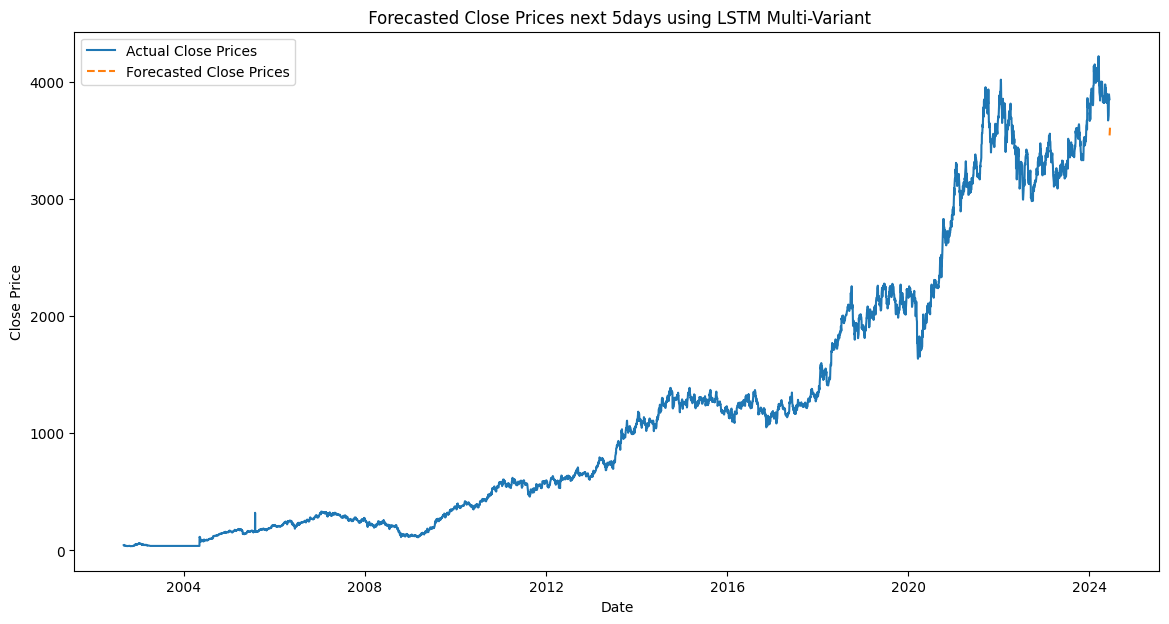

In [22]:
# Import necessary library
import pandas as pd

# Plotting the results
plt.figure(figsize=(14, 7))

# Convert 'Date' column to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(data['Date']):
    data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y') # Specify the correct format

# Plot historical closing prices
# Convert dates to naive timestamps if they are timezone-aware
plt.plot(data['Date'].dt.tz_localize(None), data['Close'], label='Actual Close Prices')

# Plot forecasted closing prices
forecasted_dates = pd.to_datetime(next_5_dates)
# Convert dates to naive timestamps if they are timezone-aware
plt.plot(forecasted_dates.tz_localize(None), forecasted_prices, label='Forecasted Close Prices', linestyle='--')



plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title(' Forecasted Close Prices next 5days using LSTM Multi-Variant')
plt.legend()
plt.show()

## s(iii) Generate_Predication_EntireData

In [23]:
# Generate predictions for the entire dataset
predicted_prices = model.predict(X_seq)
predicted_prices = scaler_Y.inverse_transform(predicted_prices)

# Prepare data for plotting
actual_prices = scaler_Y.inverse_transform(Y_scaled[time_steps:])
dates = data['Date'][time_steps:]


167/167 [==============================] - 4s 22ms/step


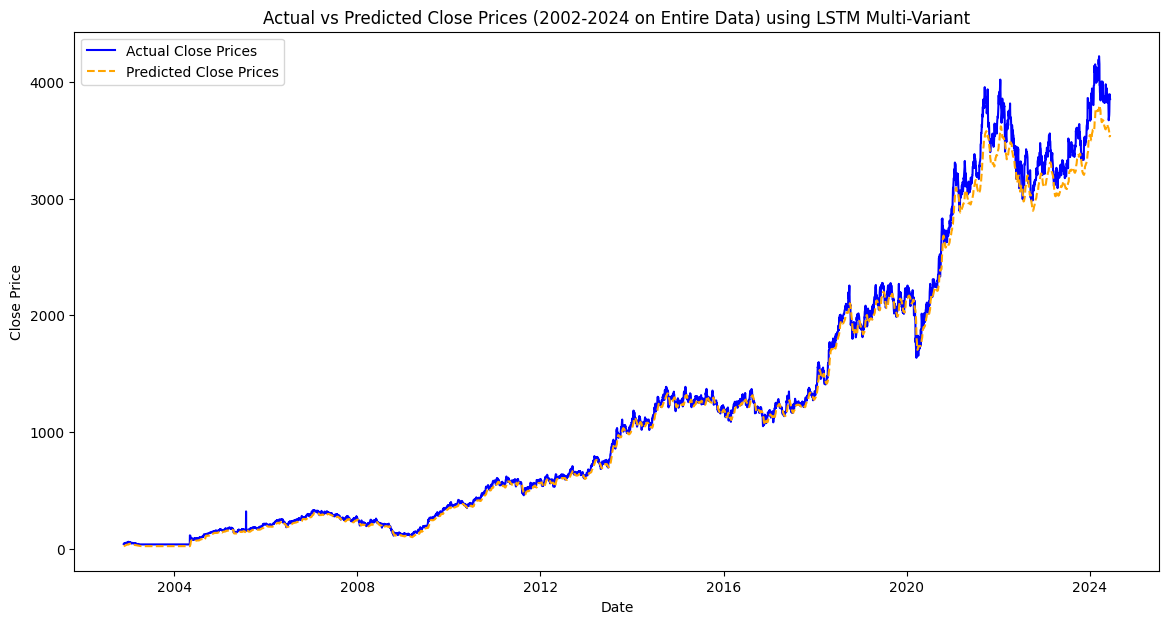

In [24]:
# Plotting the results
plt.figure(figsize=(14, 7))

# Plot actual closing prices
plt.plot(dates, actual_prices, label='Actual Close Prices', color='blue')

# Plot forecasted closing prices
plt.plot(dates, predicted_prices, label='Predicted Close Prices', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices (2002-2024 on Entire Data) using LSTM Multi-Variant')
plt.legend()
plt.show()


## s(iv) see_accuracy_RMSE

In [25]:
from sklearn.metrics import mean_squared_error, r2_score

# Use the variables you calculated previously
mse = mean_squared_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 9511.769642820052
R-squared: 0.9929720981487112


In [26]:
# Import the necessary module for regression metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming 'actual_prices' and 'predicted_prices' from previous calculations are your true and predicted values
y_test = actual_prices
y_pred = predicted_prices

# Calculate appropriate metrics for regression problems
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the calculated metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 9511.769642820052
Root Mean Squared Error (RMSE): 97.52830175297862
Mean Absolute Error (MAE): 57.72179088538535
R-squared (R2): 0.9929720981487112


# Step5: Hyper_Parameter_Tuning

## s(i) Grid_Search_CV

## s(ii) Random_Search_CV